In [1]:
import pandas as pd
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#import contractions
import numpy as np
#from ydata_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package stopwords to /home/moraa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_train = pd.read_csv('/media/moraa/New Volume/Ontita/Documents/2024_projects/Kaggle_competition/Disaster_tweets_twitter_competition/data/train.csv')
df_test = pd.read_csv('/media/moraa/New Volume/Ontita/Documents/2024_projects/Kaggle_competition/Disaster_tweets_twitter_competition/data/test.csv')

Data Exploration and Preprocessing

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
total_cells = df_train.shape[0] * df_train.shape[1]
missing_cells = df_train.isnull().sum()
missing_percentage = (missing_cells / total_cells) * 100

print(missing_percentage)

id          0.000000
keyword     0.160252
location    6.654407
text        0.000000
target      0.000000
dtype: float64


In [9]:
total_cells = df_test.shape[0] * df_test.shape[1]
missing_cells = df_test.isnull().sum()
missing_percentage = (missing_cells / total_cells) * 100

print(missing_percentage)

id          0.000000
keyword     0.199203
location    8.466135
text        0.000000
dtype: float64


In [10]:
#Delete the location column due to large number of missing values
df_train.drop(columns='location', inplace = True, axis = 1)
df_test.drop(columns='location', inplace = True, axis = 1)

In [11]:
imputer = SimpleImputer(strategy='most_frequent')

# Selecting only the 'keyword' column
keyword_column = df_train[['keyword']]

# Imputing missing values for the 'keyword' column
keyword_imputed = pd.DataFrame(imputer.fit_transform(keyword_column), columns=keyword_column.columns)

# Updating the original DataFrame with the imputed values for 'keyword' column
df_train['keyword'] = keyword_imputed

# Check the info of the DataFrame after imputation
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7613 non-null   int64 
 1   keyword  7613 non-null   object
 2   text     7613 non-null   object
 3   target   7613 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 238.0+ KB


In [12]:
imputer = SimpleImputer(strategy='most_frequent')

# Selecting only the 'keyword' column
keyword_column = df_test[['keyword']]

# Imputing missing values for the 'keyword' column
keyword_imputed = pd.DataFrame(imputer.fit_transform(keyword_column), columns=keyword_column.columns)

# Updating the original DataFrame with the imputed values for 'keyword' column
df_test['keyword'] = keyword_imputed

# Check the info of the DataFrame after imputation
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3263 non-null   int64 
 1   keyword  3263 non-null   object
 2   text     3263 non-null   object
dtypes: int64(1), object(2)
memory usage: 76.6+ KB


Removing of Stopwords, Punctuations, Special characters and Tokenizing the text

In [13]:
def preprocess_text(text):
    def remove_punctuation(text):
        if isinstance(text, str):
            return ''.join([char for char in text if char not in string.punctuation])
        else:
            return text

    def tokenize(text):
        if isinstance(text, str):
            return re.split("\W+", text.lower())
        else:
            return text

    def remove_stopwords(text):
        if isinstance(text, list):
            stopword = nltk.corpus.stopwords.words('english')
            return [word for word in text if word not in stopword]
        else:
            return text

    def remove_numbers(text):
        if isinstance(text, str):
            return re.sub(r'\d+', '', text)
        else:
            return text

    def remove_extra_spaces(text):
        if isinstance(text, str):
            return re.sub(' +', ' ', text)
        else:
            return text

    def remove_emojis(text):
        if isinstance(text, str):
            return re.sub(r'[\U00010000-\U0010ffff]', '', text)
        else:
            return text

    def remove_emoticons(text):
        if isinstance(text, str):
            return re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text)
        else:
            return text

    def remove_repeated_punctuation(text):
        if isinstance(text, str):
            return re.sub(r'(\!)\1+', r'\1', text)
        else:
            return text

    def remove_url(text):
        if isinstance(text, str):
            return re.sub(r'https?:\S*', '', text)
        else:
            return text

    # Applying the preprocessing steps
    text = remove_punctuation(text)
    text = tokenize(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    text = remove_extra_spaces(text)
    text = remove_emojis(text)
    text = remove_emoticons(text)
    text = remove_repeated_punctuation(text)
    text = remove_url(text)

    # Join the list of tokens into a single string
    if isinstance(text, list):
        text = ' '.join(text)

    return text

# Assuming df_train is your DataFrame
df_train['text_preprocessed'] = df_train['text'].apply(preprocess_text)
df_test['text_preprocessed'] = df_test['text'].apply(preprocess_text)
df_train.head()


,id,keyword,text,target,text_preprocessed
0,1,fatalities,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,fatalities,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,fatalities,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,fatalities,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,fatalities,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


In [14]:
df_test.head()

,id,keyword,text,text_preprocessed
0,0,deluged,Just happened a terrible car crash,happened terrible car crash
1,2,deluged,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
2,3,deluged,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,9,deluged,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,deluged,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 china taiwan


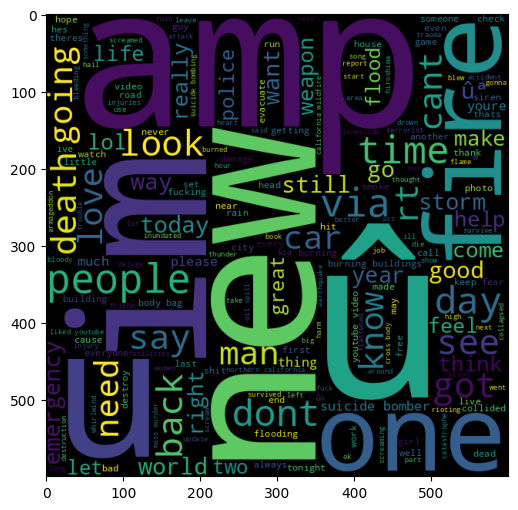

In [15]:
X=df_train['text_preprocessed']
y=df_train['target']

fig, (ax1) = plt.subplots(1, figsize=[6, 6])
wordcloud = WordCloud(background_color='black',width=600,height=600).generate(" ".join(X))
ax1.imshow(wordcloud)

Vectorization - Conveerting the processed text data into numerical representation

Machine Learning Models

In [16]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test=train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y
)

# Define the pipeline
pipeline=Pipeline(
    [('count', CountVectorizer(ngram_range=(1,1))),
     ('model', LogisticRegression(C=.8, solver='sag', max_iter=1000))]
)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('count', CountVectorizer()),
                ('model',
                 LogisticRegression(C=0.8, max_iter=1000, solver='sag'))])

In [17]:
# Predict on the testing data
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8187787261982928
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       869
           1       0.84      0.71      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



In [18]:
submission=pd.DataFrame()
submission['id']=df_test['id']
submission['target']=pipeline.predict(df_test['text_preprocessed'])
submission.to_csv('submission.csv',index=False)

The Model had a public score of 0.79374